In [10]:
from ROOT import TFile, TCanvas
import numpy as np
from Conversion.measConvSF import get_conv_sf

Welcome to JupyROOT 6.24/00


In [11]:
def get_hist(sample, histkey, channel, mass_point, syst="Central"):
    if sample == "fake":
        fkey = f"Outputs/{channel}/{mass_point}/DATA.root"
    else:
        fkey = f"Outputs/{channel}/{mass_point}/{sample}.root"
    histkey = f"{sample}/SR/{syst}/{histkey}"
    
    f = TFile.Open(fkey)
    h = f.Get(histkey)
    h.SetDirectory(0)
    f.Close()

    return h

Central: 1.1190094708068306
FakeUp: 0.6677157832438896
FakeDown: 1.4537034361468517
ElectronEnUp: 1.1190060036708764
ElectronEnDown: 1.1216176338409654
ElectronResUp: 1.1190232215074827
ElectronResDown: 1.118986644012267
MuonEnUp: 1.120322206037186
MuonEnDown: 1.121469556536051
JetEnUp: 1.1190094708068306
JetEnDown: 1.1190094708068306
JetResUp: 1.1190094708068306
JetResDown: 1.1190094708068306
L1PrefireUp: 1.1201077646119517
L1PrefireDown: 1.117954700609355
PUReweightUp: 1.146886589846604
PUReweightDown: 1.089988916593168
Central: 0.8786757841662644
FakeUp: 0.7162359352275003
FakeDown: 1.013538513808059
ElectronEnUp: 0.8806682884990165
ElectronEnDown: 0.8718040770869341
ElectronResUp: 0.8786577807673038
ElectronResDown: 0.8786754993782707
MuonEnUp: 0.883154557892486
MuonEnDown: 0.8767809067677473
JetEnUp: 0.8786757841662644
JetEnDown: 0.8786757841662644
JetResUp: 0.8786757841662644
JetResDown: 0.8786757841662644
L1PrefireUp: 0.880674071289433
L1PrefireDown: 0.8767044524657159
PUReweigh

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cvs


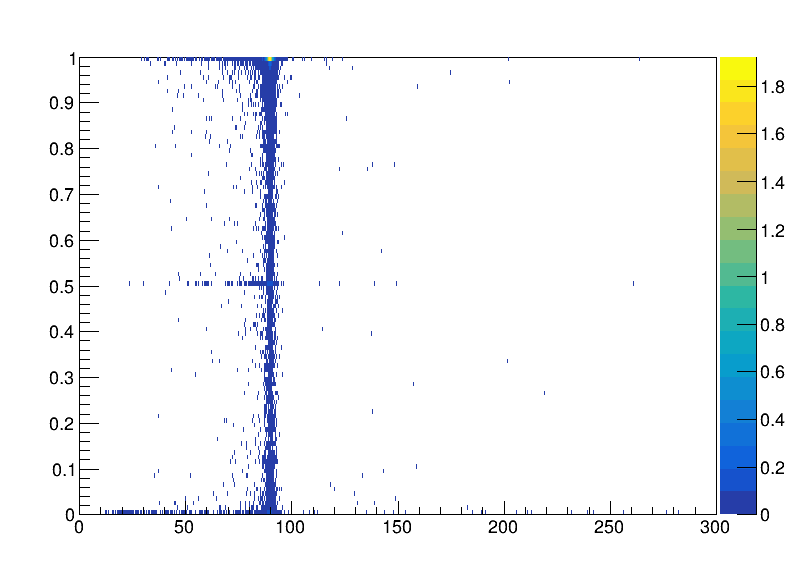

In [51]:
histkey = 'mA_score'
channel = '1E2Mu'

mass_point = 'MHc130_MA90'
signal = f"TTToHcToWA_AToMuMu_{mass_point}"
prompts = ['rare', 'ttX', 'VV']

h_signal = get_hist(signal, histkey, channel, mass_point)
h_signal.SetStats(0)

h_fake = get_hist('fake', histkey, channel, mass_point)
h_DY = get_hist("DY", histkey, channel, mass_point)
DY_sf, DY_err = get_conv_sf(channel, 'DY')
h_DY.Scale(DY_sf)
h_ZG = get_hist("ZG", histkey, channel, mass_point)
ZG_sf, ZG_err = get_conv_sf(channel, 'ZG')
h_ZG.Scale(ZG_sf)
h_conv = h_DY.Clone('conv')
h_conv.Add(h_ZG)
h_ttX = get_hist('ttX', histkey, channel, mass_point)
h_rare = get_hist('rare', histkey, channel, mass_point)
h_VV = get_hist('VV', histkey, channel, mass_point)

h_bkg = h_fake.Clone("bkg")
h_bkg.Add(h_conv)
h_bkg.Add(h_ttX)
h_bkg.Add(h_rare)
h_bkg.Add(h_VV)
h_bkg.SetStats(0)

cvs = TCanvas("cvs", "", 800, 600)
cvs.cd()
h_signal.Draw("colz")
cvs.Draw()

In [52]:
import numpy as np

mA = 90
s_start = 0.5
m_steps = np.linspace(0., 5., 51)
s_steps = np.linspace(0., 0.5, 51)

# estimate with mA only
sign_max = 0.
mA_min = 0.
mA_max = 0.
s_max = 0.
N_sig_max = 0.
N_bkg_max = 0. 
for step in m_steps:
    mA_left = h_signal.GetXaxis().FindBin(mA - step)
    mA_right = h_signal.GetXaxis().FindBin(mA + step)
    score_left = h_signal.GetYaxis().FindBin(0.)
    score_right = h_signal.GetYaxis().FindBin(1.1)
    
    N_sig = h_signal.Integral(mA_left, mA_right, score_left, score_right)
    N_bkg= h_bkg.Integral(mA_left, mA_right, score_left, score_right)
    
    # update significance
    sign= N_sig / np.sqrt(N_bkg)
    
    if sign_max < sign:
        sign_max = sign 
        mA_min = mA - step
        mA_max = mA + step
        N_sig_max = N_sig
        N_bkg_max = N_bkg  

print(sign_max, mA_min, mA_max, N_sig_max, N_bkg_max)

for s_step in s_steps:
    mA_left = h_signal.GetXaxis().FindBin(0.)
    mA_right = h_signal.GetXaxis().FindBin(300.)
    score_left = h_signal.GetYaxis().FindBin(s_start + s_step)
    score_right = h_signal.GetYaxis().FindBin(1.1)
        
    N_sig = h_signal.Integral(mA_left, mA_right, score_left, score_right)
    N_bkg= h_bkg.Integral(mA_left, mA_right, score_left, score_right)
    
    # update significance
    sign= N_sig / np.sqrt(N_bkg)
    
    if sign_max < sign and sign != np.inf:
        sign_max = sign 
        s_max = s_start + s_step
        N_sig_max = N_sig
        N_bkg_max = N_bkg
print(sign_max, s_max, N_sig_max, N_bkg_max)

for m_step in m_steps:
    for s_step in s_steps:
        mA_left = h_signal.GetXaxis().FindBin(mA - m_step)
        mA_right = h_signal.GetXaxis().FindBin(mA + m_step)
        score_left = h_signal.GetYaxis().FindBin(s_start + s_step)
        score_right = h_signal.GetYaxis().FindBin(1.1)
        
        N_sig = h_signal.Integral(mA_left, mA_right, score_left, score_right)
        N_bkg= h_bkg.Integral(mA_left, mA_right, score_left, score_right)
    
        # update significance
        sign= N_sig / np.sqrt(N_bkg)
    
        if sign_max < sign and sign != np.inf:
            sign_max = sign 
            mA_min = mA - m_step
            mA_max = mA + m_step
            s_max = s_start + s_step
            N_sig_max = N_sig
            N_bkg_max = N_bkg
             
print(sign_max, mA_min, mA_max, s_max, N_sig_max, N_bkg_max)
    

6.583217472572693 88.4 91.6 77.52119694692804 138.66425908404702
6.583217472572693 0.0 77.52119694692804 138.66425908404702
9.967958635221416 87.8 92.2 0.9 61.17346216171387 37.66289215601676


<ipython-input-52-d1a2f1e74b5c>:66: RuntimeWarning: divide by zero encountered in double_scalars
  sign= N_sig / np.sqrt(N_bkg)
